In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plot
from scipy.special import expit as sigmoid
from datetime import datetime

from scipy.spatial.distance import cosine as cos_dist
import os
import sys
import string
import json
from tensorflow.contrib.tensorboard.plugins import projector

### Create a directory
The cell below creates a directory for the tensorboard files to go into as well as where the weights and title2indx dictionary will be saved.

In [2]:
now = datetime.utcnow().strftime("%Y%m%d_%H%M");
root_logdir = "tensorFlow_logs";
logdir = "{}/run-{}/".format(root_logdir, now);

### Get Data function
The cell below defines how the data is read in and sets up the input for the rest of the model.

**Adjustable Parameters**:
* V - the number of elements or dimensions used in the word embedding. I found that 2000 gave decent results but that tensorboard's PCA calculations couldn't handle that big of embeddings.
* fileLoc - The location of the input file. **This must be changed for your set up!**

In [3]:
def remove_punctuation(s):
    s = s.replace(',', '')
    s = s.replace('.', '')
    s = s.replace('\'', '')
    s = s.replace('\"', '')
    return s

def get_data():
    V = 1000   #The max number of unique job titles. 
    
    fileLoc = "/Users/gregorycolledge/gcolledge/gcolledge/MSD_6019/allPaths.txt"
    file = open(fileLoc)
    all_titles_counts = {} #dictionary of job titles and thier counts
    
    # Count the total number of titles
    for line in file:
        path = remove_punctuation(line).split()
        if len(path) > 1:
            for title in path:
                if title not in all_titles_counts:
                    all_titles_counts[title] = 0
                all_titles_counts[title] += 1
    
    #if there are fewer titles than V, reassign it.
    V = min(len(all_titles_counts), V)
    # sort the dictionary by the number of times a title appears.
    all_titles_counts = sorted(all_titles_counts.items(), key=lambda x: x[1], reverse=True)
    
    #get the top V number of titles but reserve one for the "unknowns" which
    # is really just for anything that didn't show up enough to make the list.
    top_titles = [t for t, count in all_titles_counts[:V-1]] + ['<UNK>']
    #create a mapping from title to index for top_titles.
    title2indx = {t:i for i, t in enumerate(top_titles)}
    unk = title2indx['<UNK>']
    print("Index for the 'unknowns' is : " + str(unk))
    
    paths = [] #This will be a list of vectorized job paths.
    for line in open(fileLoc):
        path = remove_punctuation(line).split() # 'path' is the string of the path
        if len(path) > 1:    #only a path with two job titles will give any context
            p = [title2indx[t] if t in title2indx else unk for t in path] # 'p' is the vectorized path
            paths.append(p)
            
    print(paths[:3])
    print("index for 'software_engineer': " + str(title2indx["software_engineer"]))
    print("number of paths from get data: " + str(len(paths)))
    return paths, title2indx


### Negative sampling distribution
The function below defines the distribution for negative sampling. Negative sampling is used in this code as an approximation to softmax. Negative sampling is reported to be faster.

In [4]:
#negative sampling is a faster way to approximate the softmax function when using skipgram
def get_negative_sampling_distribution(paths):
    # Pn(t) = prob of title occuring
    # we would like to sample the negative samples such that
    # titles that occur more often should be sampled more often
    
    title_freq = {}
    title_count = sum(len(path) for path in paths)
    for path in paths:
        for title in path:
            if title not in title_freq:
                 title_freq[title] = 0
            title_freq[title] += 1
        
    # vocab size
    V = len(title_freq)
        
    p_neg = np.zeros(V)
    for j in range(V):
        p_neg[j] = title_freq[j]**0.75 #0.75 is an adjustable parameter.
        # This comes form the modified uniform distribution.
            
    # normalize p_neg
    p_neg = p_neg / p_neg.sum()
        
    assert(np.all(p_neg > 0))
    return p_neg

### get context
The function below gets the context words for the skipgram model. Note that this function is modified just a bit from the regular skipgram model in that it only takes context words that come after the selected position.

In [5]:
def get_context(pos, path, context_size):
    # input:
    # a path of the form: x x x pos c c c x x x
    #output:
    # the context paths: c c c 
    
#     start = max(0, pos - context_size) #this is if you want backward context as well.
    start = pos # This is for forward context only. Like next job. This is something to play around with.
    end_ = min(len(path), pos + context_size)
    
    context = []
    for context_pos, context_title_indx in enumerate(path[start:end_], start=start):
        if context_pos != pos:
            #don't include the input title itself as a target
            context.append(context_title_indx)
    return context

### Testing functions
The function below gives some indication of how well our model fits. Read it and the analogy function carefully to understand what it is reporting. More calls to analogy can be put into the test_model function.

In [6]:
def test_model(title2indx, W, V):

    indx2title = {i:t for t, i in title2indx.items()}
        # I am taking the title embedding as the average of the two weight vectors
    for word_embedding in (W, (W + V.T)/2):
        print("_______Testing_________")
        analogy('research_intern', 'graduate_research_assistant', 'intern', 'research_assistant', title2indx, indx2title, W)
        analogy('engineering_intern', 'engineer', 'software_engineering_intern', 'software_engineer', title2indx, indx2title, W)
        analogy('software_engineer', 'software_developer', 'director', 'ceo', title2indx, indx2title, W)



In [7]:
def analogy(positive1, negative1, positive2, negative2, title2indx, indx2title, W):
    V, D = W.shape
    
    print("--------------\ntesting: %s - %s = %s - %s" %(positive1, negative1, positive2, negative2))
    for t in (positive1, negative1, positive2, negative2):
        if t not in (title2indx):
            print(t + " is not in the used titles.")
            
    p1 = W[title2indx[positive1]]
    p2 = W[title2indx[positive2]]
    n1 = W[title2indx[negative1]]
    n2 = W[title2indx[negative2]]
    
    vec = p1 - n1 + n2
    
    #using the cosine distance rather than the euclidian distance.
    distances = pairwise_distances(vec.reshape(1,D), W, metric='cosine').reshape(V)
    indx = distances.argsort()[:5] #gets the index of the 5 closest vectors
    bestIndx = -1
    # remove the input titles as possibilities
    keep_out = [title2indx[t] for t in (positive1, negative1, negative2)]
    for r in indx:
        if r not in keep_out:
            bestIndx = r;
            break
     
    for i in indx:
        print(indx2title[i], distances[i])
        
    print("Distance to %s: " % positive2, cos_dist(p2, vec))

### Load Model
The model can take a long time to run, so when running the model, a number of files are saved in order to avoid needing to run the model multiple times. The Load model will read those files and give back the title2indx dictionary as well as the hidden layer weights. I have typically been using (W + V.T)/2 as the official title embedding, as seen in the test_model function. This can be changed based on future testing.

In [8]:
def load_model(directory):
    with open('%s/title2indx.json' % directory) as f:
        title2indx = json.load(f)
    npz = np.load('%s/weights.npz' % directory)
    W = npz['arr_0']
    V = npz['arr_1']
    return title2indx, W, V


## Train the Model
__DO NOT RUN THIS CELL WITHOUT READING THIS FIRST!__

This is where the magic happens! There are a number of adjustable parameters that can be tweaked as described below. This cell can take a long time to run. This is of course dependant on other parameters as well so make sure you have the parameters set the way you want them.

In this cell I am using tensorflow's "Interactive Session" which needs to be closed explicitly. The closing statment is the bottom cell. The interactive session can cause some wierd things to happen if it is left open and/or run out of order. Look [here](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession) for details.

**Adjustable parameters:**
* context_size - The size of the window used to get context words. This is a little different in this code than normal. see the get_context function above.
* learning_rate - the starting learning rate
* final_learning_rate - the final learning rate. The learning rate will change until it reaches this value.
* num_negatives - number of negative samples to use. see [this site](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) for more of a description of negative sampling.
* epochs - the number of training rounds to go through. So far, I have found that this has the largest impact on run time. I have found 300 epochs gives decent results.
* D - the word embedding size.

Index for the 'unknowns' is : 999
[[463, 51, 1, 1, 1], [999, 999, 135, 999], [62, 8, 394, 2, 394, 394]]
index for 'software_engineer': 1
number of paths from get data: 892370
Total number of titles: 5750593
epoch complete: 0 cost: 1967.2043406963348 dt: 0:00:07.991034
epoch complete: 1 cost: 1642.393219947815 dt: 0:00:07.927381
epoch complete: 2 cost: 1400.6339645385742 dt: 0:00:07.885824
epoch complete: 3 cost: 1288.9442400932312 dt: 0:00:07.817117
epoch complete: 4 cost: 1171.862764120102 dt: 0:00:07.718405
epoch complete: 5 cost: 1098.5783232450485 dt: 0:00:07.925106
epoch complete: 6 cost: 1046.9535006284714 dt: 0:00:07.971907
epoch complete: 7 cost: 959.7426824569702 dt: 0:00:08.004297
epoch complete: 8 cost: 946.9459958076477 dt: 0:00:08.203631
epoch complete: 9 cost: 885.7803808450699 dt: 0:00:07.991659
epoch complete: 10 cost: 844.0623033046722 dt: 0:00:08.123245
epoch complete: 11 cost: 823.5379295349121 dt: 0:00:07.873708
epoch complete: 12 cost: 808.398792386055 dt: 0:00:08.

epoch complete: 128 cost: 423.20723980665207 dt: 0:00:08.328235
epoch complete: 129 cost: 425.40065491199493 dt: 0:00:08.093781
epoch complete: 130 cost: 431.30132526159286 dt: 0:00:08.016805
epoch complete: 131 cost: 425.6585069298744 dt: 0:00:08.087742
epoch complete: 132 cost: 424.182391166687 dt: 0:00:08.289590
epoch complete: 133 cost: 419.48561292886734 dt: 0:00:08.067029
epoch complete: 134 cost: 425.4871554374695 dt: 0:00:07.912004
epoch complete: 135 cost: 424.6525406241417 dt: 0:00:08.195228
epoch complete: 136 cost: 426.7646389603615 dt: 0:00:08.205188
epoch complete: 137 cost: 424.9267703294754 dt: 0:00:08.694032
epoch complete: 138 cost: 421.9977750778198 dt: 0:00:08.588743
epoch complete: 139 cost: 420.8027784228325 dt: 0:00:08.115401
epoch complete: 140 cost: 423.09764724969864 dt: 0:00:08.214258
epoch complete: 141 cost: 424.00392895936966 dt: 0:00:08.174151
epoch complete: 142 cost: 425.20516431331635 dt: 0:00:08.171138
epoch complete: 143 cost: 422.88198894262314 dt: 

epoch complete: 258 cost: 413.6108285188675 dt: 0:00:08.770186
epoch complete: 259 cost: 412.18625915050507 dt: 0:00:08.216409
epoch complete: 260 cost: 407.3094576597214 dt: 0:00:08.178582
epoch complete: 261 cost: 413.4641752243042 dt: 0:00:08.623158
epoch complete: 262 cost: 413.42998218536377 dt: 0:00:08.705777
epoch complete: 263 cost: 407.9589465856552 dt: 0:00:08.692942
epoch complete: 264 cost: 415.6742743253708 dt: 0:00:08.573580
epoch complete: 265 cost: 407.69612115621567 dt: 0:00:08.255958
epoch complete: 266 cost: 409.4744441509247 dt: 0:00:08.324422
epoch complete: 267 cost: 404.27536195516586 dt: 0:00:08.776961
epoch complete: 268 cost: 409.25453251600266 dt: 0:00:08.647680
epoch complete: 269 cost: 409.8841370344162 dt: 0:00:09.415963
epoch complete: 270 cost: 415.7685214281082 dt: 0:00:08.634868
epoch complete: 271 cost: 410.7929188013077 dt: 0:00:08.694637
epoch complete: 272 cost: 411.8425949215889 dt: 0:00:08.650837
epoch complete: 273 cost: 413.88881546258926 dt: 0

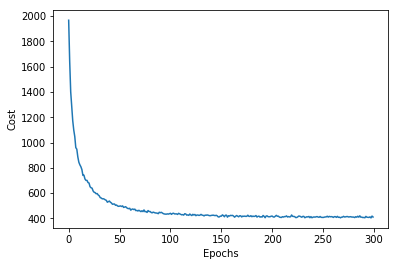

In [9]:
#train the model

directory = logdir
#get the data
paths, title2indx = get_data()
    
# number fo different titles
number_of_titles = len(title2indx)

# configuration parameters for skipgram
context_size = 3
num_negatives = 5 #number of negative sampling titles
epochs = 300;
D = 50 # word embedding size, as in NxD

#distribution for drawing negative samples
p_neg = get_negative_sampling_distribution(paths)
    
# Parameters
W = np.random.randn(number_of_titles, D).astype(np.float32) # input-to-hidden
V = np.random.randn(D, number_of_titles).astype(np.float32) #hidden-to-output
    
#create the model
with tf.name_scope("Title2Vec_place_holders"):
    tf_input = tf.placeholder(tf.int32, shape=(None,),name="Input")
    tf_negtitle = tf.placeholder(tf.int32, shape=(None,), name="Negative_Title")
    tf_context = tf.placeholder(tf.int32, shape=(None,), name="Targets/context") #targets (context)
tfW = tf.Variable(W,name="W")
tfV = tf.Variable(V.T, name="V_transposed")
    
def dot(A, B):
    C = A*B
    return tf.reduce_sum(C, axis=1)
    
#correct middle title output
emb_input = tf.nn.embedding_lookup(tfW, tf_input) # 1xD
emb_output = tf.nn.embedding_lookup(tfV, tf_context) #NxD
correct_output = dot(emb_input, emb_output) # N
    
pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones(tf.shape(correct_output)), logits=correct_output)
    
# incorrect middle title output. incorrect middle title comes from negative sampling
emb_input = tf.nn.embedding_lookup(tfW, tf_negtitle)
incorrect_output = dot(emb_input, emb_output)
    
neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros(tf.shape(incorrect_output)), logits=incorrect_output)
    
#total loss
loss = tf.reduce_mean(pos_loss) + tf.reduce_mean(neg_loss)
    
# Optimizer
train_op = tf.train.MomentumOptimizer(0.1, momentum=0.9).minimize(loss)
    
#make tensor flow session
sess = tf.InteractiveSession() #interactive so i can keep it on more cells
init_op = tf.global_variables_initializer()
    
#set up tensorboard
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
sess.run(init_op)
    
# A list to save the cost to be plotted later
#.   This will eventually be replced by tensor board stuff
costs = []
    
# number of total titles in corpus
total_titles = sum(len(path) for path in paths)
print("Total number of titles:", total_titles)
  
# for subsampling each sentence
threshold = 1e-5
p_drop = 1 - np.sqrt(threshold / p_neg)
    
#train the model
for epoch in range(epochs):
    #randomize what order we see the paths
    np.random.shuffle(paths)
        
    #accumulate the cost
    cost = 0;
    counter = 0;
    inputs = []
    targets = []
    negtitles = []
    t0 = datetime.now()
    for path in paths:
        #keep only some of the titles based on p_neg, this is for speeding up the training. We may need to play around with this to see if it is really helping.
        path = [t for t in path if np.random.random() < (1 - p_drop[t])]
        if len(path) < 2: #if the path is too short to be useful, move on to the next path.
            continue
            
        #pick randomly which order to see the middle titles so we don't always see samples in the same order
        randomly_ordered_positions = np.random.choice(len(path),
                                                         size=len(path),
                                                         replace=False)
            
        for j, pos in enumerate(randomly_ordered_positions):
            # title is the "input title" that we will find the context titles around.
            title = path[pos]
                
            #get the positive context titles/negative samples
            context_titles = get_context(pos, path, context_size)
            neg_title = np.random.choice(number_of_titles, p=p_neg) #this is a single negative middle word
            #the negative middle word is put with the context words for the negative samples
                
            n = len(context_titles)
            inputs += [title]*n
            negtitles += [neg_title]*n
            targets += context_titles

        if len(inputs) >= 64:    #batch size of 64
                
                # Run one iteration of the network.                 
            _, c = sess.run((train_op, loss),
                            feed_dict={tf_input: inputs,
                                       tf_negtitle: negtitles,
                                       tf_context: targets})
            cost += c
              
            #reset the batch
            inputs = []
            targets = []
            negtitles = []
                    
        counter += 1
#         if counter % 100 == 0:
#                 #may want to replace this with tensorboard stuff
#             print("processed %s / %s\r" % (counter, len(paths)))    
                
    # print stuff so we know things are working
    dt = datetime.now() - t0
    print("epoch complete:", epoch, "cost:", cost, "dt:", dt)
            
    #save the cost
    costs.append(cost)
        
    #tensor board update
    summary_str = loss_summary.eval(session=sess, feed_dict={loss:cost})
    file_writer.add_summary(summary_str, epoch)
            
#plot the cost per iteration
plot.plot(range(len(costs)), costs)
plot.xlabel("Epochs")
plot.ylabel("Cost")
plot.show()
        
#get parameters
W, VT = sess.run((tfW, tfV))
V = VT.T   

#save the model
if not os.path.exists(directory):
    os.mkdir(directory)
            
with open('%s/title2indx.json' % directory, 'w') as f:
    json.dump(title2indx, f)
            
np.savez('%s/weights.npz' % directory, W, V)
        
# #return the model
# return title2indx, W, V

### Tensorboard embedding visualization
The cells below are my attempt to get the 3d representation of the title embeddings in tensorboard. I have not been very successful in this attempt, so the cells below don't have to be run. Also note that at the time of writing this, the things that do show up in tensorboard are labeled incorrectly.

In [10]:
embedding_shape = (tf.cast(W.shape[0], tf.int32), tf.cast(W.shape[1],tf.int32))
embedding_var = tf.Variable(tf.zeros(embedding_shape ), 
                            name='W_embedding')
# assign the tensor that we want to visualize to the embedding variable
embedding_assign = embedding_var.assign(tfW)

In [11]:
from tensorflow.contrib.tensorboard.plugins import projector

# Create a config object to write the configuration parameters
config = projector.ProjectorConfig()
config.model_checkpoint_path = os.path.join(directory, "model.ckpt")

# Add embedding variable
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# # Link this tensor to its metadata file (e.g. labels) -> we will create this file later
# embedding.metadata_path = 'metadata.tsv'

# # Specify where you find the sprite. -> we will create this image later
# embedding.sprite.image_path = 'sprite_images.png'
# embedding.sprite.single_image_dim.extend([img_w, img_h])

# Write a projector_config.pbtxt in the logs_path.
# TensorBoard will read this file during startup.
projector.visualize_embeddings(file_writer, config)

In [12]:
# a cell I have been using for debugging
print(tf_context.shape)
type(W)
print(W.shape)


(?,)
(1000, 50)


In [13]:
# Run session to evaluate the tensor
w_emb = sess.run(embedding_assign, feed_dict={tf_context:targets})

# Save the tensor in model.ckpt file
saver = tf.train.Saver()
saver.save(sess, os.path.join(directory, "model.ckpt"), epochs)

'tensorFlow_logs/run-20181212_2345/model.ckpt-300'

### This is where I run the test function

In [14]:
directory = "/Users/gregorycolledge/gcolledge/gcolledge/MSD_6019/Notebooks/tensorFlow_logs/run-20181101_allPaths"

t, w, v = load_model(directory)
test_model(t, w, v)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gregorycolledge/gcolledge/gcolledge/MSD_6019/Notebooks/tensorFlow_logs/run-20181101_allPaths/title2indx.json'

In [ ]:
print(type(w))
print(w.shape)
print(w[t['intern']])

print(type(v))
print(v.shape)
print(v[t['intern']])

#### Close the session!
This needs to be run after the training cell is run.

In [ ]:
sess.close()